<a href="https://colab.research.google.com/github/edison0828/generative_ai/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW8: ⚖️ 台灣民法 RAG 問答助理

本次作業目標在建立一個使用 **檢索增強生成 (Retrieval-Augmented Generation, RAG)** 技術的智慧問答助理，專門回答與**台灣民法**相關的問題。

**運作流程：**

1.  使用者輸入問題。
2.  (運用對話歷史) 重寫查詢，使其更清晰獨立。
3.  使用嵌入模型將重寫後的查詢轉換為向量。
4.  在預先建立的民法 FAISS 向量索引中搜尋最相關的法條片段。
5.  將檢索到的法條片段、對話歷史和使用者最新問題組合，傳送給 OpenAI 模型。
6.  模型根據提供的上下文和歷史生成回答，並透過 Gradio 介面串流輸出。

## 下載 "faiss_db.zip"

In [27]:
!pip install gdown

url = "https://drive.google.com/uc?export=download&id=1w-dcgmpgTZuTqprfdUWX8AZXJgCXSUj3"
output_filename = "faiss_db.zip"

!gdown "{url}" -O {output_filename}

Downloading...
From: https://drive.google.com/uc?export=download&id=1w-dcgmpgTZuTqprfdUWX8AZXJgCXSUj3
To: /content/faiss_db.zip
100% 595k/595k [00:00<00:00, 35.1MB/s]


In [28]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
replace faiss_db/index.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: faiss_db/index.pkl      
replace faiss_db/index.faiss? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: faiss_db/index.faiss    


## 安裝並引入必要套件

In [29]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

In [30]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.schema import Document

In [31]:
from openai import OpenAI
import gradio as gr
import os
import time
import openai
from google.colab import userdata

## 設定 OpenAI API Key

In [32]:
try:
    api_key = userdata.get('OpenAI')
    if not api_key:
        raise ValueError("OpenAI API Key not found in Colab secrets. Please add it.")
    os.environ['OPENAI_API_KEY'] = api_key
    client = openai.OpenAI()
    MODEL = "gpt-4o"
    print("OpenAI Client Initialized Successfully.")
except Exception as e:
    print(f"Error initializing OpenAI Client: {e}")
    client = None

OpenAI Client Initialized Successfully.


## 設定參數與路徑

In [33]:
FAISS_DB_FOLDER = "faiss_db"
EMBEDDING_MODEL_NAME = 'intfloat/multilingual-e5-small'
LLM_MODEL_NAME = "gpt-4o"
TOP_K = 5 # 檢索數量

print("參數設定完成:")
print(f"  FAISS 資料夾: {FAISS_DB_FOLDER}")
print(f"  嵌入模型: {EMBEDDING_MODEL_NAME}")
print(f"  LLM 模型: {LLM_MODEL_NAME}")
print(f"  檢索數量 (Top K): {TOP_K}")

參數設定完成:
  FAISS 資料夾: faiss_db
  嵌入模型: intfloat/multilingual-e5-small
  LLM 模型: gpt-4o
  檢索數量 (Top K): 5


## 準備 FAISS 索引資料

In [34]:
if not os.path.exists(FAISS_DB_FOLDER) or not os.path.isdir(FAISS_DB_FOLDER):
    print(f"錯誤：找不到 FAISS 資料夾 '{FAISS_DB_FOLDER}'。")
    print("請確保你已經將 'faiss_db' 資料夾 (包含 index.faiss 和 index.pkl) 上傳到 Colab 或掛載了 Google Drive。")
    raise FileNotFoundError(f"FAISS 資料夾 '{FAISS_DB_FOLDER}' 不存在或不是一個目錄。")
else:
    print(f"成功找到 FAISS 資料夾: '{FAISS_DB_FOLDER}'")
    print("資料夾內容:", os.listdir(FAISS_DB_FOLDER))
    if not os.path.exists(os.path.join(FAISS_DB_FOLDER, "index.faiss")):
        print(f"警告：在 {FAISS_DB_FOLDER} 中找不到 index.faiss 文件")
    if not os.path.exists(os.path.join(FAISS_DB_FOLDER, "index.pkl")):
         print(f"警告：在 {FAISS_DB_FOLDER} 中找不到 index.pkl 文件")

成功找到 FAISS 資料夾: 'faiss_db'
資料夾內容: ['index.faiss', 'index.pkl']


## 定義自訂 Embedding 類別

In [35]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

print("CustomE5Embedding 類別已定義。")


CustomE5Embedding 類別已定義。


## 載入嵌入模型和 FAISS 索引/Retriever

In [36]:
embedding_model = None
db = None
retriever = None

try:
    print(f"正在載入嵌入模型: {EMBEDDING_MODEL_NAME}...")
    embedding_model = CustomE5Embedding(model_name=EMBEDDING_MODEL_NAME)
    print("嵌入模型載入完成。")

    print(f"正在從 {FAISS_DB_FOLDER} 載入 FAISS 索引...")
    # 載入 FAISS 索引
    db = FAISS.load_local(
        FAISS_DB_FOLDER,
        embedding_model,
        allow_dangerous_deserialization=True
    )
    print("FAISS 索引載入完成。")

    # 建立 Retriever
    retriever = db.as_retriever(search_kwargs={'k': TOP_K})
    print(f"Retriever 建立完成，將檢索 Top {TOP_K} 文件。")

except Exception as e:
    print(f"錯誤：載入嵌入模型或 FAISS 索引/Retriever 失敗: {e}")
    raise e


正在載入嵌入模型: intfloat/multilingual-e5-small...
嵌入模型載入完成。
正在從 faiss_db 載入 FAISS 索引...
FAISS 索引載入完成。
Retriever 建立完成，將檢索 Top 5 文件。


## 定義 RAG 核心函數

In [39]:
def get_rag_response(user_query, chat_history):
    print(f"\n--- 收到查詢: {user_query} ---")
    print(f"--- 對話歷史: {chat_history} ---")

    # 查詢重寫
    rewritten_query = user_query # 預設為原始查詢
    if chat_history: # 只有在有歷史記錄時才需要重寫
        try:
            print("1a. 正在重寫查詢以包含上下文...")
            rewrite_messages = []
            # 只包含最近幾輪的歷史，避免過長
            history_to_consider = chat_history[-3:] # 只看最近3輪
            for h_query, h_response in history_to_consider:
                rewrite_messages.append({"role": "user", "content": h_query})
                rewrite_messages.append({"role": "assistant", "content": h_response})
            rewrite_messages.append({"role": "user", "content": f"根據以上對話，請將我最新的問題改寫成一個獨立、清晰、適合用於向量資料庫搜尋的查詢：'{user_query}'"})

            rewrite_system_prompt = "你的任務是根據對話歷史，將使用者最新的問題改寫成一個自包含的搜尋查詢，以便在法律文件中查找相關資訊。只輸出改寫後的查詢，不要包含其他說明。"
            rewrite_messages.insert(0, {"role": "system", "content": rewrite_system_prompt})

            # 呼叫 LLM 進行重寫
            rewrite_response = client.chat.completions.create(
                model=MODEL,
                messages=rewrite_messages,
                temperature=0.0,
                max_tokens=100
            )
            rewritten_query = rewrite_response.choices[0].message.content.strip().replace('"', '')
            print(f"1b. 重寫後的查詢: {rewritten_query}")

        except Exception as e:
            print(f"錯誤：查詢重寫失敗: {e}")
            rewritten_query = user_query

    try:
        print(f"1. 正在使用 LangChain Retriever 搜尋 Top {TOP_K} 相關文本 (基於重寫查詢: {rewritten_query})...")
        retrieved_docs: list[Document] = retriever.get_relevant_documents(rewritten_query)

        if not retrieved_docs:
            print("警告：未能從 FAISS 檢索到任何相關文本。")
            context = "找不到相關的法條片段。"
        else:
            # 將檢索到的文檔內容組合成上下文
            context = "\n\n---\n\n".join([doc.page_content for doc in retrieved_docs])
            print(f"2. 檢索到的相關法條片段 (部分預覽):\n{context[:500]}...")

    except Exception as e:
        print(f"錯誤：檢索過程中發生錯誤: {e}")
        yield "抱歉，在查找相關法條時發生錯誤。"
        return

    try:
        print("3. 正在建構 Prompt (包含歷史) 並呼叫 OpenAI...")
        system_prompt = """
        你是個專精於台灣民法的AI助理。請根據**先前的對話內容**和以下提供的**[相關法條片段]**來回答使用者**最新的問題**。
        你的回答應該：
        1.  **優先基於**提供的[相關法條片段]回答最新的問題，可以的話盡量列出是第幾條法條片段。
        2.  如果片段為"找不到相關的法條片段。"，請在回答開頭告知使用者，然後**根據你自己的知識和之前的對話內容**來回答，並明確說明這是基於你的內部知識，而非提供的法條。
        3.  如果提供的片段不足以完整回答最新問題，請先根據片段回答，然後**可以根據你自己的知識或參考之前的對話**進行補充，但要明確說明補充資訊的來源 (非來自當前片段)。
        4.  你的回答需要連貫之前的對話。
        5.  如果最新問題與提供的片段完全無關，請說明片段不包含相關資訊，然後嘗試根據對話歷史或自身知識回答。
        6.  使用繁體中文回答。
        """

        messages = [{"role": "system", "content": system_prompt}]
        for human_msg, ai_msg in chat_history:
            messages.append({"role": "user", "content": human_msg})
            messages.append({"role": "assistant", "content": ai_msg})

        # 這裡還是放原始的 user_query，LLM 需要知道使用者「實際上」問了什麼
        final_user_prompt = f"""
        [相關法條片段]
        {context}

        ---
        [我最新的問題]
        {user_query}

        ---
        請根據上述[相關法條片段]和之前的對話，回答我最新的問題。
        """
        messages.append({"role": "user", "content": final_user_prompt})

        response = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            stream=True,
            temperature=0.2,
            max_tokens=1000
        )

        full_text = ""
        print("4. 正在從 OpenAI Stream 回應...")
        for chunk in response:
            if chunk.choices and chunk.choices[0].delta and chunk.choices[0].delta.content:
                content = chunk.choices[0].delta.content
                full_text += content
                yield full_text

        print(f"--- Stream 結束，完整回應 (後端日誌):\n{full_text[:500]}...")


    except openai.APIError as e:
        print(f"錯誤：OpenAI API 返回錯誤: {e}")
        yield f"抱歉，與語言模型通訊時發生 API 錯誤: {e}"
    except Exception as e:
        print(f"錯誤：生成回應過程中發生錯誤: {e}")
        import traceback
        traceback.print_exc()
        yield "抱歉，處理您的請求時發生內部錯誤。"

print("RAG 核心函數 get_rag_response 已定義。")

RAG 核心函數 get_rag_response 已定義。


In [41]:
print("\n--- 準備啟動 Gradio 介面 ---")

# 檢查必要元件是否準備好
if not retriever:
    print("錯誤：Retriever 未初始化，無法啟動介面。。")
elif not client:
    print("錯誤：OpenAI Client 未初始化，無法啟動介面。")

else:
    chatbot = gr.ChatInterface(
        fn=get_rag_response,
        title="⚖️ 民法 RAG 問答助理 ",
        description="輸入你關於台灣民法的問題，我會嘗試根據相關法條片段來回答。\n ",
        examples=[
            ["借用人如果無法返還同種類、品質、數量的物品時（例如借的是特定品牌的絕版酒），該如何處理？"],
            ["如果員工因為不是自己的錯而無法提供勞務（例如生病請假符合公司規定），僱主是否仍需支付報酬？"],
            ["業主可以在工作還沒完成前，就隨時決定不做了（終止契約）嗎？如果可以，需要承擔什麼後果？"]
        ],
        chatbot=gr.Chatbot(height=500),
        textbox=gr.Textbox(placeholder="請在此輸入您的民法問題...", container=False, scale=7),
        theme="soft"
    )

    print("正在啟動 Gradio 介面... 請稍候，將會產生一個公開連結。")
    chatbot.launch(share=True, debug=True)


--- 準備啟動 Gradio 介面 ---


<ipython-input-41-cb25a24afdd1>:19: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(height=500),
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:321: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


正在啟動 Gradio 介面... 請稍候，將會產生一個公開連結。
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://37705468458687c864.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



--- 收到查詢: 如果員工因為不是自己的錯而無法提供勞務（例如生病請假符合公司規定），僱主是否仍需支付報酬？ ---
--- 對話歷史: [] ---
1. 正在使用 LangChain Retriever 搜尋 Top 5 相關文本 (基於重寫查詢: 如果員工因為不是自己的錯而無法提供勞務（例如生病請假符合公司規定），僱主是否仍需支付報酬？)...
2. 檢索到的相關法條片段 (部分預覽):
第 487-1 條
第 488 條
第 489 條
第 490 條
第 491 條
第 492 條
第 493 條
第 494 條
第 495 條
第 496 條
第 497 條
第 498 條
得之利益，僱用人得由報酬額內扣除之。
受僱人服勞務，因非可歸責於自己之事由，致受損害者，得向僱用人請求
賠償。
前項損害之發生，如別有應負責任之人時，僱用人對於該應負責者，有求
償權。
僱傭定有期限者，其僱傭關係，於期限屆滿時消滅。
僱傭未定期限，亦不能依勞務之性質或目的定其期限者，各當事人得隨時
終止契約。但有利於受僱人之習慣者，從其習慣。
當事人之一方，遇有重大事由，其僱傭契約，縱定有期限，仍得於期限屆
滿前終止之。
前項事由，如因當事人一方之過失而生者，他方得向其請求損害賠償。
第 八 節 承攬
第 八 節 承攬
稱承攬者，謂當事人約定，一方為他方完成一定之工作，他方俟工作完成
，給付報酬之契約。
約定由承攬人供給材料者，其材料之價額，推定為報酬之一部。
如依情形，非受報酬即不為完成其工作者，視為允與報酬。
未定報酬額者，按照價目表所定給付之；無價目表者，按照習慣給付。

---

受僱...
3. 正在建構 Prompt (包含歷史) 並呼叫 OpenAI...
4. 正在從 OpenAI Stream 回應...
--- Stream 結束，完整回應 (後端日誌):
根據提供的[相關法條片段]，特別是僱傭相關的規定，並沒有直接提到在受僱人因非可歸責於自己之事由（如生病）無法提供勞務時，僱用人是否仍需支付報酬。然而，根據第 487-1 條的精神，如果受僱人因非可歸責於自己之事由受損害，得向僱用人請求賠償，這可能暗示僱用人有某種程度的責任。

基於我的內部知識，通常在實務上，若員工因病請假且符合公司規定，僱主通常仍需支付一定的病假薪資，這可能依據勞動法規或公司內部政策而有所

## 實際使用範例截圖

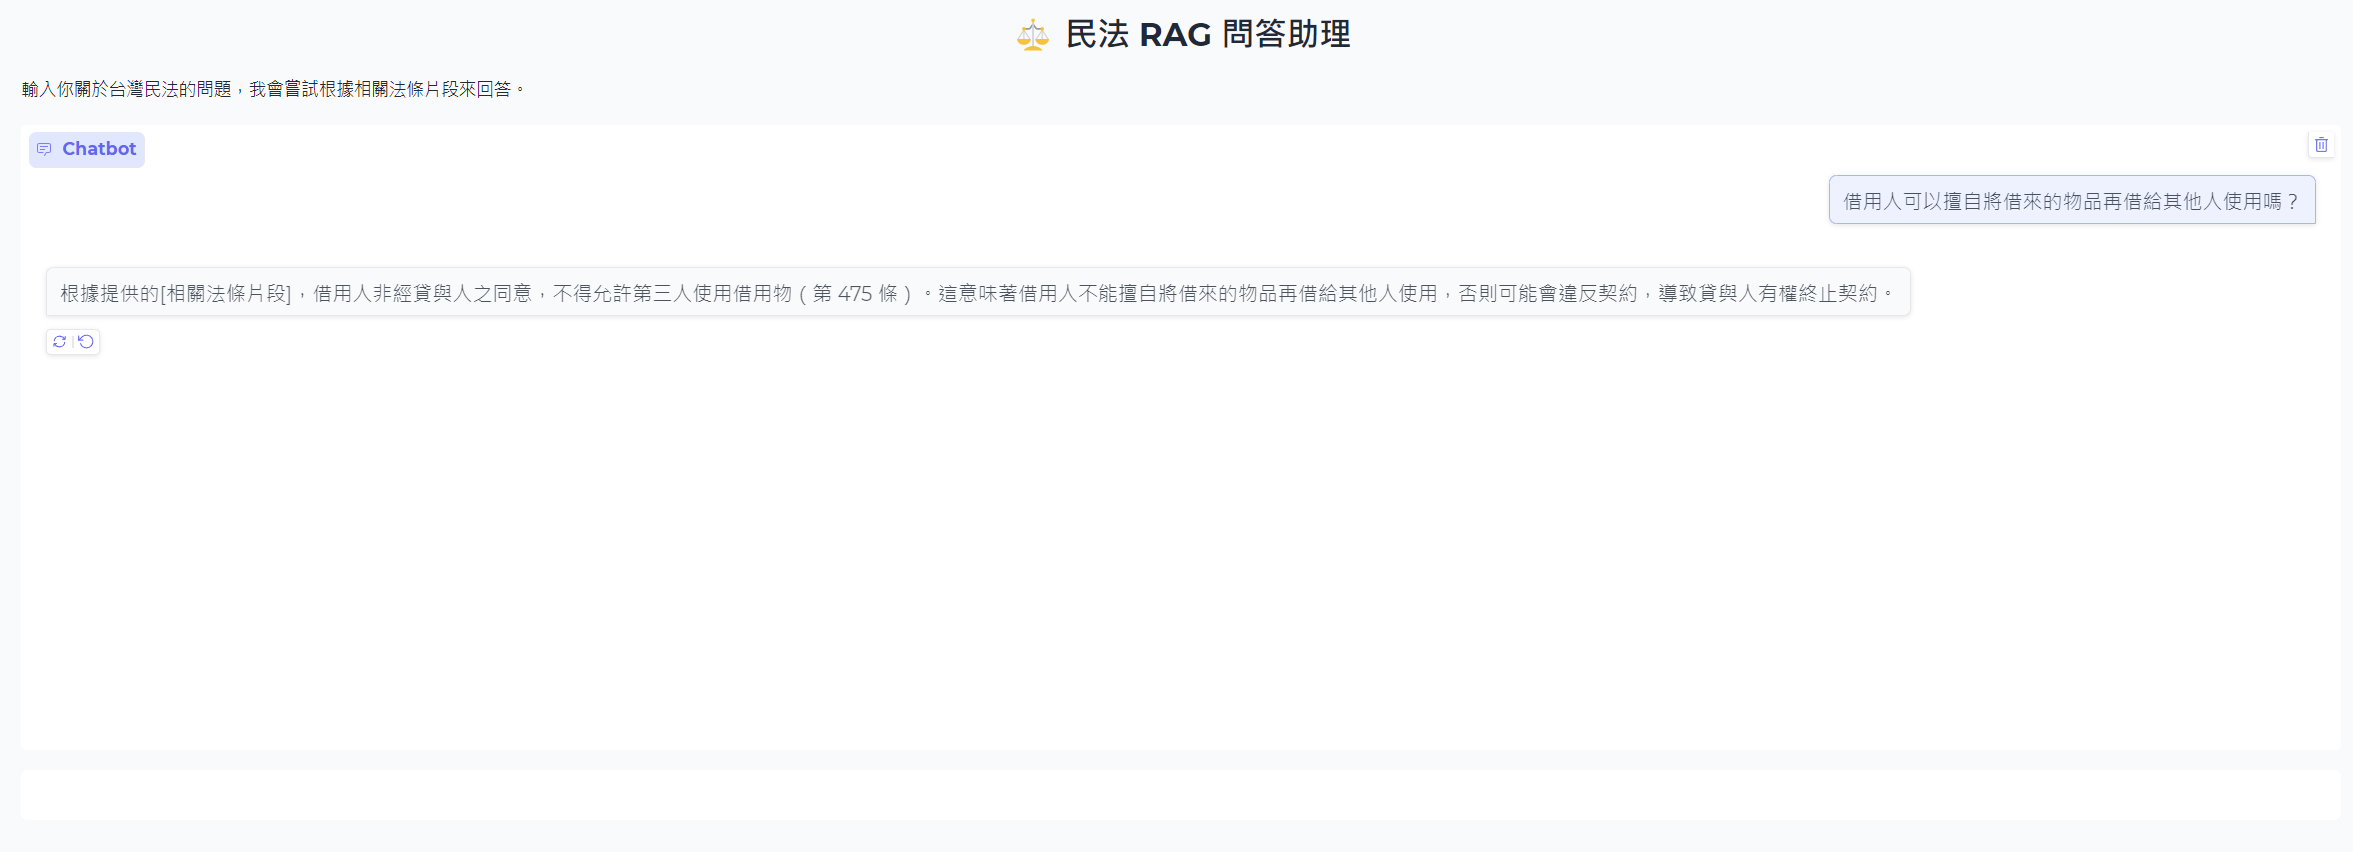

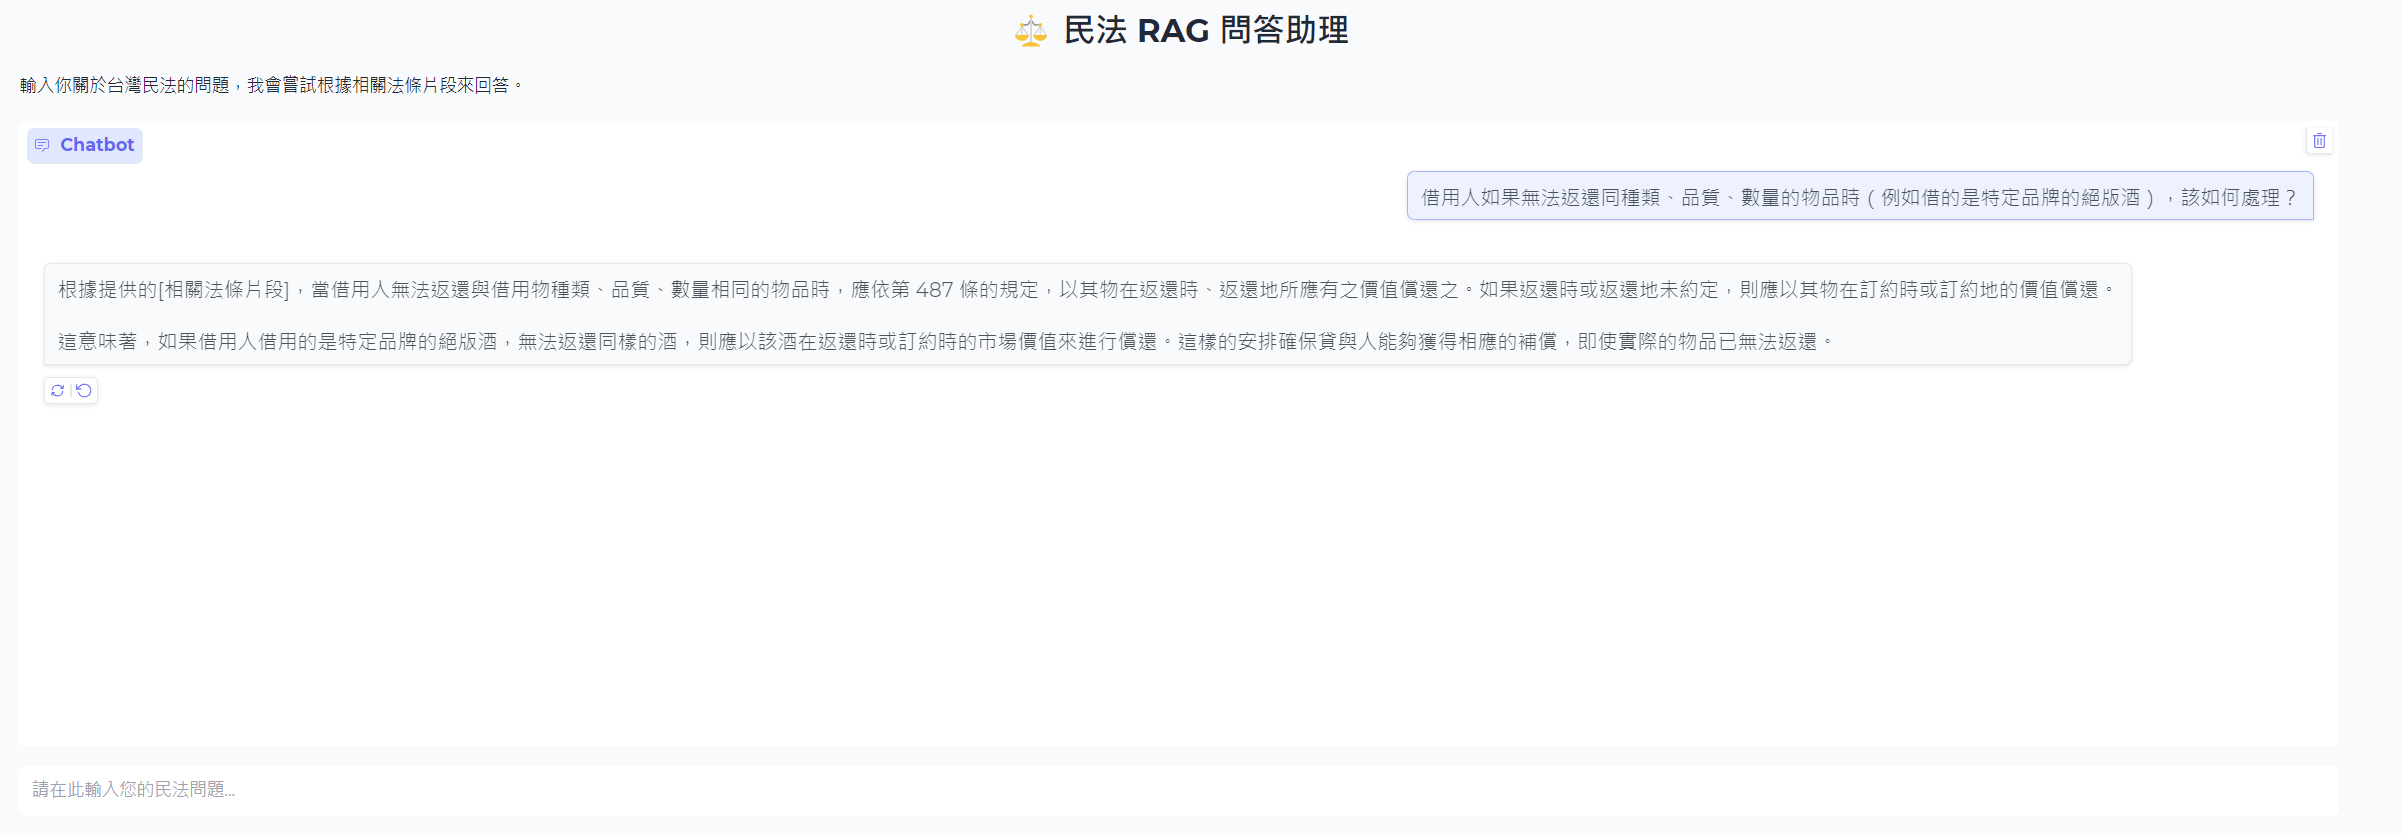